# QNN on Pynq

This notebook covers how to use low quantized Neural Networks on Pynq for inference on MNIST dataset by using LFC network composed of 4 fully connected layers with 1024 neurons each. There are 2 networks using different precision: 

- LFCW1A1 using 1 bit weights and 1 activation,
- LFCW1A2 using 1 bit weights and 2 activation

In [1]:
import bnn

## 1. LFC and MNIST

This notebook performs inference on MNIST test set from http://yann.lecun.com/exdb/mnist/ which contains 10000 pictures of handwritten digits. The LFC network requires MNIST formatted input data, that's why the binary test file can be directly loaded. All other images have to be formatted to this specification (refer to url and LFC webcam examples).

At first you need to download mnist test set and labels using wget and unzip the archive as shown below:
In order to be able to compare the inferred classes against the expected labels we first read the labels:

In [2]:
#get
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz 
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz 
#unzip    
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

#read labels
labels = []
with open("/home/xilinx/jupyter_notebooks/bnn/t10k-labels-idx1-ubyte","rb") as lbl_file:
    #read magic number and number of labels (MSB first) -> MNIST header
    magicNum = int.from_bytes(lbl_file.read(4), byteorder="big")
    countLbl = int.from_bytes(lbl_file.read(4), byteorder="big")
    #now the labels are following byte-wise
    for idx in range(countLbl):
        labels.append(int.from_bytes(lbl_file.read(1), byteorder="big"))
    lbl_file.close()
len(labels)

10000

## 2. Hardware Inference

First of all a classifier needs to be instantiated. Using the LfcClassifier will allow to classify MNIST formatted images utilizing LFC network. There are two different runtimes available: hardware accelerated and pure software environment.

Once a classifier is instantiated the inference on MNIST images can be started using `classify_mnist` or `classify_mnists` methods - for both single and multiple images.

### Case 1: 
##### W1A1 - 1 bit weights and 1 bit activation

In [3]:
lfcW1A1_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"mnist",bnn.RUNTIME_HW)
lfcW1A1_classifier.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
result_W1A1 = lfcW1A1_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/t10k-images-idx3-ubyte")

Inference took 28040.00 microseconds, 2.80 usec per image
Classification rate: 356633.39 images per second


### Case 2: 
#### W1A2 - 1 bit weights and 2 bit activation

In [5]:
lfcW1A2_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A2,"mnist",bnn.RUNTIME_HW)

In [6]:
result_W1A2 = lfcW1A2_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/t10k-images-idx3-ubyte")

Inference took 28040.00 microseconds, 2.80 usec per image
Classification rate: 356633.39 images per second


# 3. Software accelerated inference

In comparison to previous runs the inference can be performed in pure software runtime utilizing PYNQs ARM core. Let's only take the first 10 pictures to get results within a narrow time frame:

In [7]:
with open("/home/xilinx/jupyter_notebooks/bnn/10_mnist_pictures", "wb") as out_file:
    with open("/home/xilinx/jupyter_notebooks/bnn/t10k-images-idx3-ubyte","rb") as img_file:
        #copy magic number
        out_file.write(img_file.read(4))
        #set number of images
        img_file.read(4)
        out_file.write(bytearray.fromhex('0000000A'))        
        #copy row and column information
        out_file.write(img_file.read(8))
        
        #copy 10 pictures (one is 28x28, 1 pixel is 1 byte)
        out_file.write(img_file.read(28*28*10))
        img_file.close()
        out_file.close()

Start inference

In [8]:
print("SW Inference with W1A1:")
sw_lfcW1A1_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"mnist",bnn.RUNTIME_SW)
sw_resultW1A1 = sw_lfcW1A1_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/10_mnist_pictures")
print("\nSW Inference with W1A2:")
sw_lfcW1A2_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A2,"mnist",bnn.RUNTIME_SW)
sw_resultW1A2 = sw_lfcW1A2_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/10_mnist_pictures")

SW Inference with W1A1:
Inference took 171891.99 microseconds, 17189.20 usec per image
Classification rate: 58.18 images per second

SW Inference with W1A2:
Inference took 1282747.97 microseconds, 128274.80 usec per image
Classification rate: 7.80 images per second


As it can be seen, pure software runtime is much slower.

## 4. Summary

### Inference time

##### Hardware

Results can be visualized using matplotlib. The inference time per image is accessible through the classifier. Here you can see hardware vs software execution times per image in microseconds:

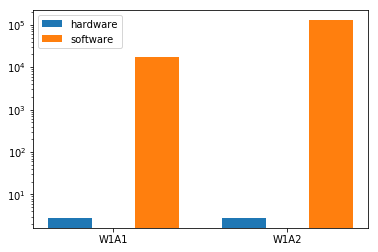

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

hw_time = [lfcW1A1_classifier.usecPerImage,
           lfcW1A2_classifier.usecPerImage]
sw_time = [sw_lfcW1A1_classifier.usecPerImage,
           sw_lfcW1A2_classifier.usecPerImage]

x_axis = ('W1A1', 'W1A2')

y_pos = np.arange(len(x_axis))
plt.bar(y_pos-0.25, hw_time, 0.25)
plt.bar(y_pos+0.25, sw_time, 0.25)
plt.xticks(y_pos, x_axis)
plt.legend(["hardware","software"])
plt.semilogy()
plt.show()

### Accuracy

In [10]:
#compare against labels
countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W1A1[idx]:
        countRight += 1
accuracyW1A1 = countRight*100/len(labels)

countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W1A2[idx]:
        countRight += 1
accuracyW1A2 = countRight*100/len(labels)

print("Accuracy W1A1: ", accuracyW1A1)
print("Accuracy W1A2: ", accuracyW1A2)

Accuracy W1A1:  98.4
Accuracy W1A2:  98.49


## 5. Reset the device

In [11]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()